#Importing libraries and dataset

In [ ]:
import nltk
import pandas as pd
from nltk.corpus import stopwords
from textblob import Word
from sklearn.preprocessing import LabelEncoder
from collections import Counter
import wordcloud
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

import numpy as np
import seaborn as sns
from sklearn.utils import resample
import re

from sklearn.feature_extraction.text import TfidfVectorizer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

from tensorflow import keras
from keras import layers

In [ ]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
from google.colab import files
uploaded = files.upload()



Saving data.csv to data.csv


In [ ]:
df = pd.read_csv("data.csv")
df.head(10)

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
5,$SPY wouldn't be surprised to see a green close,positive
6,Shell's $70 Billion BG Deal Meets Shareholder ...,negative
7,SSH COMMUNICATIONS SECURITY CORP STOCK EXCHANG...,negative
8,Kone 's net sales rose by some 14 % year-on-ye...,positive
9,The Stockmann department store will have a tot...,neutral


#Data preprocessing

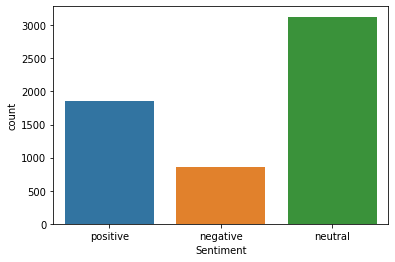

In [ ]:
sns.countplot(x=df.Sentiment);

In [ ]:
df['Sentiment'].value_counts()

neutral     3130
positive    1852
negative     860
Name: Sentiment, dtype: int64

In [ ]:
x,y=df['Sentence'],df['Sentiment']

In [ ]:
# data cleaning

stopWords = set(stopwords.words("english"))
def cleaning(df):
  df = df.lower()
  df = word_tokenize(str(df))
  df = [re.sub('[^A-Za-z]+', '', word) for word in df]
  df = [t for t in df if t not in stopWords]
  df = [WordNetLemmatizer().lemmatize(t) for t in df]
  df = [PorterStemmer().stem(t) for t in df]
  df = ' '.join(df)

  return df



In [ ]:
#final_corpus_list=cleaning(df)
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords

df['Sentence'] = df['Sentence'].apply(cleaning)
df['Sentence'].head()

lb=LabelEncoder()
df['Sentiment']=lb.fit_transform(df['Sentiment'])




In [ ]:
# Maximum number of words to be used
MAX_NB_WORDS = 60000
# Max number of words in each sequence.
MAX_SEQUENCE_LENGTH = 200

EMBEDDING_DIM = 100
tokenizer = keras.preprocessing.text.Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)

tokenizer.fit_on_texts(df['Sentence'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 9043 unique tokens.


In [ ]:


X = tokenizer.texts_to_sequences(df['Sentence'].values)
X = keras.preprocessing.sequence.pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5842, 200)


In [ ]:

#Y = pd.get_dummies(training_df['sentiment']).values
Y = pd.get_dummies(df['Sentiment']).values
print(Y.shape)

(5842, 3)


#LSTM Modeling

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3, random_state = 50)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(4089, 200) (4089, 3)
(1753, 200) (1753, 3)


In [ ]:
model = keras.Sequential()
model.add(keras.layers.Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(keras.layers.SpatialDropout1D(0.2))
model.add(keras.layers.LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(keras.layers.Dense(3, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

epochs = 5
batch_size = 32

history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,validation_split=0.3)

Epoch 1/5
90/90 [==============================] - 46s 480ms/step - loss: 0.9702 - accuracy: 0.5314 - val_loss: 0.9070 - val_accuracy: 0.5852
Epoch 2/5
90/90 [==============================] - 46s 514ms/step - loss: 0.7086 - accuracy: 0.6929 - val_loss: 0.8442 - val_accuracy: 0.6504
Epoch 3/5
90/90 [==============================] - 42s 468ms/step - loss: 0.4316 - accuracy: 0.8309 - val_loss: 0.8933 - val_accuracy: 0.6398
Epoch 4/5
90/90 [==============================] - 43s 482ms/step - loss: 0.2679 - accuracy: 0.8882 - val_loss: 0.9741 - val_accuracy: 0.6267
Epoch 5/5
90/90 [==============================] - 43s 480ms/step - loss: 0.1997 - accuracy: 0.9158 - val_loss: 1.2975 - val_accuracy: 0.6218


#Result

In [ ]:
score = model.evaluate(X_test,y_test)
print(score)

55/55 [==============================] - 3s 57ms/step - loss: 1.1524 - accuracy: 0.6543
[1.152431607246399, 0.6543068885803223]


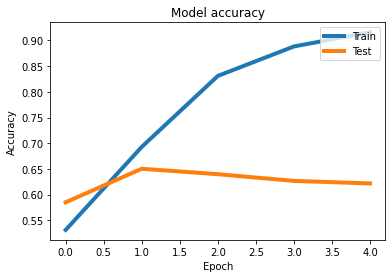

In [ ]:
# History for accuracy
import matplotlib.pyplot as plt
#plt.plot(history.history['accuracy'])
#plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'],linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.plot(history.history['val_accuracy'],linewidth=4, markersize=12,)
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

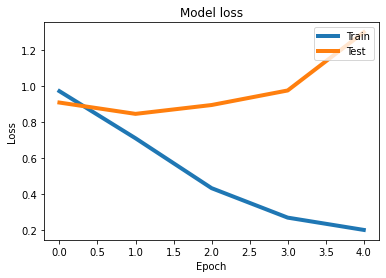

In [ ]:
# History for loss
#plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'],linewidth=4, markersize=12, markeredgewidth=4, markeredgecolor='navy')
plt.plot(history.history['val_loss'],linewidth=4, markersize=12,)
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()